In [1]:
import matplotlib.pyplot as plt
import numpy as np
# import scipy.io
from torch.optim import Adagrad, Adam
import torch.nn.functional as F
import torch
# import seaborn as sns

from gglm.glm.base import GLM
from gglm.glm.mmdglm import MMDGLM
# from gglm.cnncritic import MMDCritic
# from gglm.utils import shift_array
from kernel.fun import KernelFun
from sptr.sptr import SpikeTrain
# from kernel.rect import KernelRect

%load_ext autoreload
%autoreload 2

In [2]:
# tau = 10
# weight = torch.from_numpy(KernelFun.gaussian_delta(tau).interpolate(np.arange(-4*tau, 4*tau, 1)))[None, None, :]

# def kernel(r1_i, r2):
#     aux1 = F.conv1d(r1_i.T[:, None, :].double(), weight, padding=(weight.shape[2] - 1) // 2)
#     aux2 = F.conv1d(r2.T[:, None, :].double(), weight, padding=(weight.shape[2] - 1) // 2)
# #     print(aux1.shape, aux2.shape)
#     return torch.sum(aux1 * aux2, dim=(1, 2))

In [3]:
import sys
import matplotlib as mpl
sys.path.append('/home/diego/Dropbox/hold_noise/mpl_styles/')

from nips import *
for key, val in paper.items():
    mpl.rcParams[key] = val
palette = dict(d='C0', ml='C2', mmd='C1')    

[151 201 185 153 171 186 206 169 160 230]
Starting gradient ascent... 

 Iteration 105 of 200 | Elapsed time: 0.69 seconds | objective=8528.03
 
 Iteration 105 of 200 | Converged | Elapsed time: 0.0115 minutes | Log posterior is not monotonic 

u0 true/fit -4 -3.9928987057730008


(array([ 98., 277., 242., 168., 105.,  97.,  90.,  68.,  69.,  55.,  49.,
         48.,  40.,  35.,  37.,  25.,  31.,  15.,  19.,  28.,  16.,  23.,
         16.,  11.,  10.,  13.,   8.,   7.,   7.,   9.,   7.,   9.,   6.,
          6.,   2.,   6.,   4.,   3.,   4.]),
 array([  0,   5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,
         65,  70,  75,  80,  85,  90,  95, 100, 105, 110, 115, 120, 125,
        130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190,
        195]),
 <a list of 39 Patch objects>)

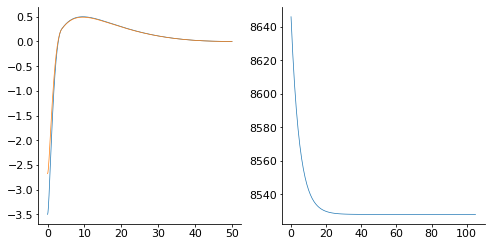

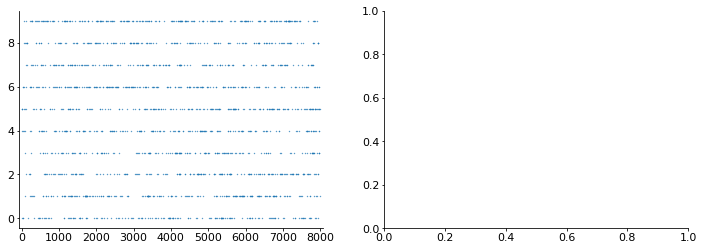

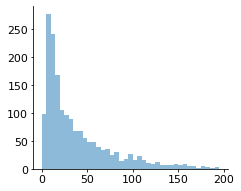

In [34]:
# num_epochs = 200
# lr = 5e-2

def raised_cosine(t, phi, a, c):
    return (1 + np.cos(np.maximum(-np.pi, np.minimum(a * np.log(t + c) - phi, np.pi)))) / 2

n = 10
# eta_true = KernelFun.exponential([50], coefs=[-5])
# eta_true = KernelFun.exponential([10, 20], coefs=[4., -4.])
eta_true = KernelFun(raised_cosine, basis_kwargs=dict(phi=np.array([0, np.pi * 1.5])), 
                     shared_kwargs=dict(a=2e0, c=1e0), coefs=np.array([-3.5, 0.5]), support=[0, 50])
glm_true = GLM(u0=-4, eta=eta_true.copy())

t = np.arange(0, 8000, 1)
_, _, mask_spikes_te = glm_true.sample(t, shape=(n,))
print(np.sum(mask_spikes_te, 0))
mask_spikes_te_torch = torch.from_numpy(mask_spikes_te.copy())
st_dc = SpikeTrain(t, mask_spikes_te)
isi_d = st_dc.isi_distribution()

# eta_fit = KernelFun.exponential([50], coefs=[0])
# eta_fit = KernelFun.exponential([10, 20], coefs=[2, -3])
eta_fit = KernelFun(raised_cosine, basis_kwargs=dict(phi=np.array([0, np.pi * 1.5])), 
                     shared_kwargs=dict(a=2e0, c=1e0), coefs=np.array([-2, 0]), support=[0, 50])

glm_fit = GLM(u0=-3.6, eta=eta_fit.copy())
opt = glm_fit.fit(st_dc.t, st_dc.mask, verbose=True, newton_kwargs=dict(stop_cond=1e-12))

u_fr_ml, r_fr_ml, mask_spikes_fr_ml = glm_fit.sample(t, shape=(n, ))
mask_spikes_fr_ml_torch = torch.from_numpy(mask_spikes_fr_ml.copy())

print('u0 true/fit', glm_true.u0, glm_fit.u0)
fig, (ax1, ax2) = plt.subplots(figsize=(8, 4), ncols=2)
glm_true.eta.plot(ax=ax1)
glm_fit.eta.plot(ax=ax1)
ax2.plot(opt.obj_iterations)

fig, (ax1, ax2) = plt.subplots(figsize=(12, 4), nrows=1, ncols=2)
st_dc.plot(ax=ax1, marker='.', ms=0.7)

bins = np.arange(0, 200, 5)
fig, ax = plt.subplots()
ax.hist(isi_d, alpha=0.5, bins=bins)
# ax.plot([mu_d, mu_d], [0, 200], 'C0--')
# ax.plot([mu2_d**0.5, mu2_d**0.5], [0, 200], 'C0-')
# ax.plot([mu3_d**(1/3), mu3_d**(1/3)], [0, 200], 'C0-x')

In [42]:
lam_mmd = 1e0 # isi_mean
def kernel(t, mask_spikes1, mask_spikes2):
    isi1 = SpikeTrain(t, mask_spikes1.numpy()).isi_distribution(concatenate=False)
    isi2 = SpikeTrain(t, mask_spikes2.numpy()).isi_distribution(concatenate=False)
    n1 = int(np.max(np.sum(mask_spikes1.numpy(), 0)) - 1)
    n2 = int(np.max(np.sum(mask_spikes2.numpy(), 0)) - 1)
    isi1 = np.stack([np.append(_isi, np.zeros(n1 - len(_isi)) * np.nan) for _isi in isi1], 0)
    isi2 = np.stack([np.append(_isi, np.zeros(n2 - len(_isi)) * np.nan) for _isi in isi2], 0)
    diff_isi = isi1[:, None, :, None] - isi2[None, :, None, :]
    gramian = np.nansum(np.exp(-(diff_isi)**2 / 1e1), axis=(2, 3))
#     gramian += np.nansum(np.exp(-(diff_isi)**2 / 1e0), axis=(2, 3))
#     gramian += np.nansum(np.exp(-(diff_isi)**2 / 1e2), axis=(2, 3))
    gramian = torch.from_numpy(gramian)
    return gramian
phi, kernel = None, kernel

In [36]:
n_batch = 20

idx_d = np.triu_indices(n, k=1)
idx_d = (torch.from_numpy(idx_d[0]), torch.from_numpy(idx_d[1]))
idx = np.triu_indices(n_batch, k=1)
idx = (torch.from_numpy(idx[0]), torch.from_numpy(idx[1]))

mmd = []
for ii in range(5):
    _, _, _mask_spikes_fr_ml = glm_fit.sample(t, shape=(n_batch,))
    _mask_spikes_fr_ml = torch.from_numpy(_mask_spikes_fr_ml)

    norm1 = torch.mean(kernel(t, mask_spikes_te_torch, mask_spikes_te_torch)[idx_d])
    norm2 = torch.mean(kernel(t, _mask_spikes_fr_ml, _mask_spikes_fr_ml)[idx])
    dot = torch.mean(kernel(t, mask_spikes_te_torch, _mask_spikes_fr_ml))
    mmd.append(norm1 + norm2 - 2 * dot)
    
mean_mmd_ml = np.mean(mmd)
sd_mmd_ml = np.std(mmd)

In [48]:
# eta_fit = KernelFun.exponential([50, 200], coefs=[4, -5])
# mmdglm = MMDGLM(u0=-4, eta=eta_fit.copy())

# kernel = KernelFun.gaussian_delta(50)

# eta_fit = KernelFun.exponential([100, 200], coefs=[2., -3.])
# eta_fit = KernelFun.exponential([100, 200], coefs=[0., 0.])
eta_fit = KernelFun(raised_cosine, basis_kwargs=dict(phi=np.array([0, np.pi * 1.5])), 
                     shared_kwargs=dict(a=2e0, c=1e0), coefs=np.array([-3., 0.2]), support=[0, 50])
mmdglm = MMDGLM(u0=-5, eta=eta_fit.copy())

# mmdglm = MMDGLM(u0=float(glm_true.u0), eta=glm_true.eta.copy())

n_batch_fr = 25
# n_batch_fr, n_batch = n, 1
num_epochs = 450
iterations = np.arange(1, num_epochs + 1, 1)
# lr = 1e-5 * torch.ones(num_epochs)
# lr[75:] = 1e-6
lr = 1e-6 * torch.ones(num_epochs)
lr[75:] = 1e-7
lr[150:] = 1e-8
# lr[225:] = 1e-9
# lr[400:] = 5e-5
# lr = lr * 5e-1
# lr = 1e-2 / torch.arange(1, num_epochs + 1, 1).double()**0.1
# lr = 1e-2 / torch.arange(1, num_epochs + 1, 1).double()**0.35
# lr = 1e-2 / torch.arange(1, num_epochs + 1, 1).double()**0.7

loss, mmd, metrics_list = mmdglm.train(t, mask_spikes_te_torch, phi=phi, kernel=kernel, log_likelihood=False, lam_mmd=lam_mmd, 
                                       biased=False, biased_mmd=False, control_variates=True, lr=lr, 
                                            num_epochs=num_epochs, n_batch_fr=n_batch_fr, verbose=True, metrics=None)
loss, mmd = np.array(loss), np.array(mmd)

 epoch 449 of 450 loss 177724.5657658772

### retrain

In [124]:
_lr, _num_epochs = 1e-7 * torch.ones(num_epochs), 100
_loss, _mmd, _metrics_list = mmdglm.train(t, mask_spikes_te_torch, phi=phi, kernel=kernel, log_likelihood=False, lam_mmd=lam_mmd, 
                                       biased=False, biased_mmd=False, control_variates=True, lr=_lr, 
                                            num_epochs=_num_epochs, n_batch_fr=n_batch_fr, verbose=True, metrics=None)
loss, mmd = np.append(loss, np.array(_loss)), np.append(mmd, np.array(_mmd))
lr = torch.cat((lr, _lr))
iterations = np.append(iterations, iterations[-1] + np.arange(1, _num_epochs + 1, 1))

 epoch 249 of 250 loss 19650.4648825912

### plot


 181.2 174.12

u0 true/fit -4 -4.006652788041232


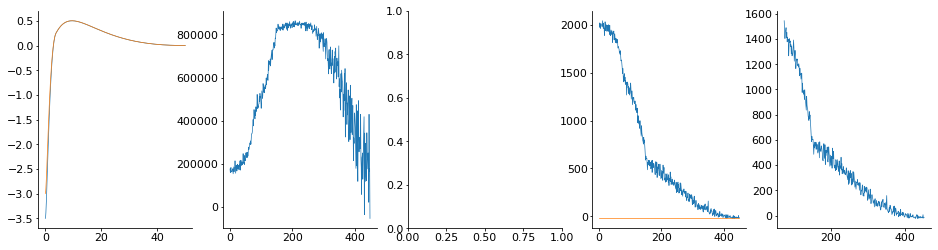

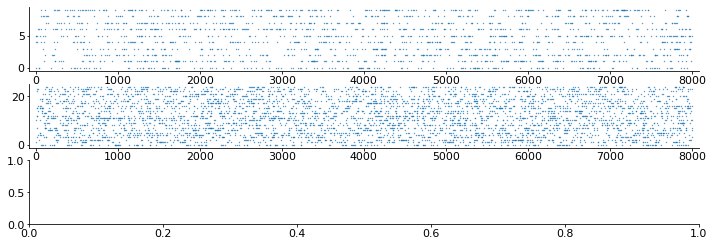

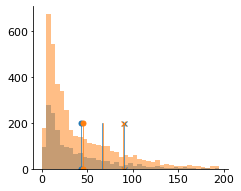

In [49]:
u_new_fr, r_fr_mmd, mask_spikes_fr_mmd = mmdglm.sample(t, shape=(n_batch_fr, ))
st_fr_mmd = SpikeTrain(t, mask_spikes_fr_mmd)

print('\n', np.mean(np.sum(mask_spikes_te, 0)), np.mean(np.sum(mask_spikes_fr_mmd, 0)))
print('\nu0 true/fit', glm_true.u0, mmdglm.u0)

# iterations = np.arange(1, num_epochs + 1, 1)
iterations = np.arange(1, len(mmd) + 1, 1)
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(figsize=(16, 4), ncols=5)
glm_true.eta.plot(ax=ax1)
mmdglm.eta.plot(ax=ax1)
ax2.plot(loss)
# ax3.plot(nll)
# ax4.plot(loss - nll)
ax4.plot(iterations, mmd)
ax4.plot([1, num_epochs], [mean_mmd_ml, mean_mmd_ml])
ax5.plot(iterations[75:], mmd[75:])

fig, (ax1, ax2, ax3) = plt.subplots(figsize=(12, 4), nrows=3, ncols=1)
st_dc.plot(ax=ax1, marker='.', ms=0.7)
st_fr_mmd.plot(ax=ax2, marker='.', ms=0.7)

isi_fr_mmd = st_fr_mmd.isi_distribution()
mu_d = np.mean(isi_d)
mu_fr = np.mean(isi_fr_mmd)
mu2_d = np.mean(isi_d**2)
mu2_fr = np.mean(isi_fr_mmd**2)
mu2_d = np.mean(isi_d**2)
mu2_fr = np.mean(isi_fr_mmd**2)
mu3_d = np.mean(isi_d**3)
mu3_fr = np.mean(isi_fr_mmd**3)

bins = np.arange(0, 200, 5)
fig, ax = plt.subplots()
ax.hist(isi_d, alpha=0.5, bins=bins)
ax.hist(isi_fr_mmd, alpha=0.5, bins=bins)
ax.plot([mu_d, mu_d], [0, 200], 'C0-o')
ax.plot([mu_fr, mu_fr], [0, 200], 'C1-o')
ax.plot([mu2_d**0.5, mu2_d**0.5], [0, 200], 'C0-')
ax.plot([mu2_fr**0.5, mu2_fr**0.5], [0, 200], 'C1-')
ax.plot([mu3_d**(1/3), mu3_d**(1/3)], [0, 200], 'C0-x')
ax.plot([mu3_fr**(1/3), mu3_fr**(1/3)], [0, 200], 'C1-x')

In [23]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [24]:
import sys
import matplotlib as mpl

sys.path.append('/home/diego/Dropbox/hold_noise/mpl_styles/')

from nips import *
for key, val in paper.items():
    mpl.rcParams[key] = val
palette = dict(d='C0', ml='C2', mmd='C1')    

<ipython-input-50-a1ca82d29997>:68: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


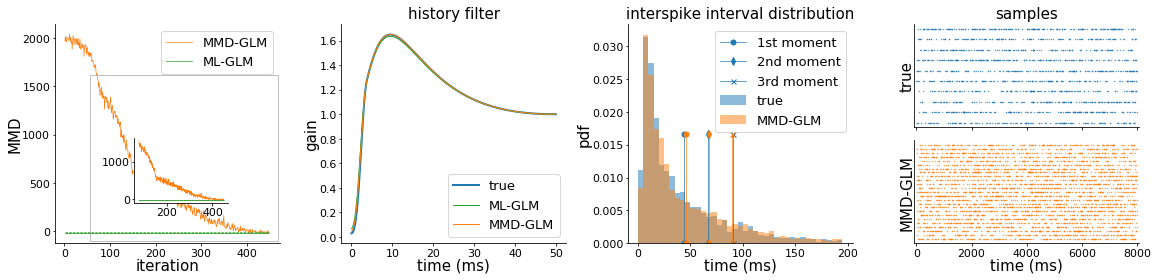

In [50]:
# fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(figsize=(20, 4), ncols=5)
fig = plt.figure(figsize=(20, 4))
ax1 = plt.subplot2grid((2, 5), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((2, 5), (0, 1), rowspan=2)
ax3 = plt.subplot2grid((2, 5), (0, 2), rowspan=2)
ax4 = plt.subplot2grid((2, 5), (0, 3), rowspan=1)
ax5 = plt.subplot2grid((2, 5), (1, 3), rowspan=1, sharex=ax4)

ax1.plot(iterations, mmd, label='MMD-GLM', color=palette['mmd'])
ax1.plot([1, num_epochs], [mean_mmd_ml, mean_mmd_ml], label='ML-GLM', color=palette['ml'])
ax1.plot([1, num_epochs], [mean_mmd_ml - sd_mmd_ml, mean_mmd_ml - sd_mmd_ml], '--', color=palette['ml'])
ax1.plot([1, num_epochs], [mean_mmd_ml + sd_mmd_ml, mean_mmd_ml + sd_mmd_ml], '--', color=palette['ml'])
# ax1.fill_between([1, num_epochs], mean_mmd_ml - sd_mmd_ml, mean_mmd_ml + sd_mmd_ml, alpha=0.5, label='ML-GLM', color=palette['ml'])
ax1.set_xlabel('iteration')
ax1.set_ylabel('MMD')
ax1.legend()
axins1 = inset_axes(ax1, width=1.3, height=0.9, bbox_to_anchor=(.2, .01, .6, .5),
                   bbox_transform=ax1.transAxes)
axins1.plot(iterations[75:], mmd[75:], color=palette['mmd'])
axins1.plot([75, num_epochs], [mean_mmd_ml, mean_mmd_ml], label='ML-GLM', color=palette['ml'])
axins1.plot([75, num_epochs], [mean_mmd_ml - sd_mmd_ml, mean_mmd_ml - sd_mmd_ml], '--', color=palette['ml'])
axins1.plot([75, num_epochs], [mean_mmd_ml + sd_mmd_ml, mean_mmd_ml + sd_mmd_ml], '--', color=palette['ml'])
# axins1.fill_between([75, num_epochs], mean_mmd_ml - sd_mmd_ml, mean_mmd_ml + sd_mmd_ml, alpha=0.5, label='ML-GLM', color=palette['ml'])
ax1.indicate_inset_zoom(axins1)

glm_true.eta.plot(ax=ax2, exp_values=True, lw=2, label='true', color=palette['d'])
glm_fit.eta.plot(ax=ax2, exp_values=True, lw=1, label='ML-GLM', color=palette['ml'])
mmdglm.eta.plot(ax=ax2, exp_values=True, lw=1, label='MMD-GLM', color=palette['mmd'])
ax2.set_title('history filter')
ax2.set_xlabel('time (ms)'); ax2.set_ylabel('gain')
ax2.legend()

ax3.set_title('interspike interval distribution')
ax3.hist(isi_d, alpha=0.5, density=True, bins=bins, label='true', color=palette['d'])
ax3.hist(isi_fr_mmd, alpha=0.5, density=True, bins=bins, label='MMD-GLM', color=palette['mmd'])
yf = ax3.get_ylim()[1] / 2
ax3.plot([mu_d, mu_d], [0, yf], 'C0-o', label='1st moment', color=palette['d'])
ax3.plot([mu_fr, mu_fr], [0, yf], 'C1-o', color=palette['mmd'])
ax3.plot([mu2_d**0.5, mu2_d**0.5], [0, yf], 'C0-d', label='2nd moment', color=palette['d'])
ax3.plot([mu2_fr**0.5, mu2_fr**0.5], [0, yf], 'C1-d', color=palette['mmd'])
ax3.plot([mu3_d**(1/3), mu3_d**(1/3)], [0, yf], 'C0-x', label='3rd moment', color=palette['d'])
ax3.plot([mu3_fr**(1/3), mu3_fr**(1/3)], [0, yf], 'C1-x', color=palette['mmd'])
ax3.set_xlabel('time (ms)')
ax3.set_ylabel('pdf')
ax3.legend()

ax4.set_title('samples')
st_dc.plot(ax=ax4, marker='.', ms=0.7, color=palette['d'])
st_fr_mmd.plot(ax=ax5, marker='.', ms=0.7, color=palette['mmd'])
ax5.set_xlabel('time (ms)')
ax5.set_ylabel('trials')


# ax4.set_xlabel('time (ms)')
# ax4.set_ylabel('trials')
# ax4.set_yticks([0, 19]); ax4.set_yticklabels([1, 20])
# ax4.set_title('true')
# ax5.set_yticks([1, 20])
# ax5.set_yticks([0, 19]); ax5.set_yticklabels([1, 20])
# ax5.set_title('MMD-GLM')

ax4.tick_params(axis='x', labelbottom=False)
ax4.set_ylabel('true')
ax4.set_yticks([])
ax5.set_ylabel('MMD-GLM')
ax5.set_yticks([])

fig.tight_layout()
fig.savefig('/home/diego/Dropbox/generative_glm/figures/history_filter.pdf', transparent=True, bbox_inches='tight')

In [ ]:
# lam_mmd = 1e-2
# def mean_isi(t, mask_spikes):
#     isi = SpikeTrain(t, mask_spikes.numpy()).isi_distribution(concatenate=False)
#     isi = torch.tensor([np.mean(_isi) for _isi in isi]).double()
#     return isi
# phi, kernel = mean_isi, None

# lam_mmd = 1e-8
# def mean2_isi(t, mask_spikes):
#     isi = SpikeTrain(t, mask_spikes.numpy()).isi_distribution(concatenate=False)
#     isi = torch.tensor([np.mean(_isi**2) for _isi in isi]).double()
#     return isi
# phi, kernel = mean2_isi, None

# lam_mmd = 1e-2 # doesn't really minimize first nor second moments
# def mean_and_mean2_isi(t, mask_spikes):
#     isi = SpikeTrain(t, mask_spikes.numpy()).isi_distribution(concatenate=False)
#     isi = torch.tensor([np.mean(_isi) + np.mean((_isi)**2)**0.5 for _isi in isi]).double()
#     return isi
# phi, kernel = mean_and_mean2_isi, None

# lam_mmd = 1e-2 # isi_mean
# def kernel(t, mask_spikes1, mask_spikes2):
#     isi1 = SpikeTrain(t, mask_spikes1.numpy()).isi_distribution(concatenate=False)
#     isi2 = SpikeTrain(t, mask_spikes2.numpy()).isi_distribution(concatenate=False)
#     mu_isi1 = torch.tensor([np.mean(_isi) for _isi in isi1]).double()
#     mu_isi2 = torch.tensor([np.mean(_isi) for _isi in isi2]).double()
#     mu2_isi1 = torch.tensor([np.mean(_isi**2) for _isi in isi1]).double()**0.5
#     mu2_isi2 = torch.tensor([np.mean(_isi**2) for _isi in isi2]).double()**0.5
# #     gramian = np.exp(isi1[:, None] * isi2[None, :] / 5e3)
#     gramian = mu_isi1[:, None] * mu_isi2[None, :] + mu2_isi1[:, None] * mu2_isi2[None, :]
#     return gramian
# phi, kernel = None, kernel

# lam_mmd = 1e-8 # isi_mean
# def phi(t, mask_spikes):
#     isi = SpikeTrain(t, mask_spikes.numpy()).isi_distribution(concatenate=False)
#     isi = torch.tensor([np.mean(np.exp((_isi / 1e5))) for _isi in isi]).double()
#     return isi

# lam_mmd = 1e0 # isi_mean
# def phi(t, mask_spikes):
#     isi = SpikeTrain(t, mask_spikes.numpy()).isi_distribution(concatenate=False)
#     isi = torch.tensor([np.mean(_isi) for _isi in isi]).double()
# #     print(isi)
#     isi = torch.exp(-isi / 5e3)
#     return isi

# lam_mmd = 1e0 # isi_mean
# def kernel(t, mask_spikes1, mask_spikes2):
#     isi1 = SpikeTrain(t, mask_spikes1.numpy()).isi_distribution(concatenate=False)
#     isi1 = torch.tensor([np.mean(_isi) for _isi in isi1]).double()
#     isi2 = SpikeTrain(t, mask_spikes2.numpy()).isi_distribution(concatenate=False)
#     isi2 = torch.tensor([np.mean(_isi) for _isi in isi2]).double()
#     gramian = torch.exp(-(isi1[:, None] - isi2[None, :])**2 / 1e2)
#     return gramian
# phi, kernel = None, kernel

lam_mmd = 1e0 # isi_mean
def kernel(t, mask_spikes1, mask_spikes2):
    isi1 = SpikeTrain(t, mask_spikes1.numpy()).isi_distribution(concatenate=False)
    isi2 = SpikeTrain(t, mask_spikes2.numpy()).isi_distribution(concatenate=False)
    n1 = int(np.max(np.sum(mask_spikes1.numpy(), 0)) - 1)
    n2 = int(np.max(np.sum(mask_spikes2.numpy(), 0)) - 1)
#     isi1_m = np.zeros((mask_spikes1.shape[0], n1)) * np.nan
#     isi2_m = np.zeros((mask_spikes2.shape[0], n2)) * np.nan
    isi1 = np.stack([np.append(_isi, np.zeros(n1 - len(_isi)) * np.nan) for _isi in isi1], 0)
    isi2 = np.stack([np.append(_isi, np.zeros(n2 - len(_isi)) * np.nan) for _isi in isi2], 0)
    gramian = np.nansum(np.exp(-(isi1[:, None, :, None] - isi2[None, :, None, :])**2 / 1e1), axis=(2, 3))
#     isi1 = torch.tensor([np.mean(_isi) for _isi in isi1]).double()
#     isi2 = torch.tensor([np.mean(_isi) for _isi in isi2]).double()
#     gramian = np.zeros((len(isi1), len(isi2)))
#     for ii, _isi1 in enumerate(isi1):
#         for jj, _isi2 in enumerate(isi2):
# #             gramian[ii, jj] = np.sum([np.exp(-(tau1 - _isi2)**2 / 1e1) for tau1 in _isi1])
#             gramian[ii, jj] = np.sum(np.exp(-(_isi1[:, None] - _isi2[None, :])**2 / 1e1))

    gramian = torch.from_numpy(gramian)
    return gramian
phi, kernel = None, kernel

In [54]:
a = torch.arange(9).view(3, 3).double()
# a[0, 0] = np.nan
a.fill_diagonal_(0)
# print(a)
# torch.sum(a)

tensor([[0., 1., 2.],
        [3., 0., 5.],
        [6., 7., 0.]], dtype=torch.float64)

In [15]:
gramian_d_d = torch.randn(100, 100)
aux = torch.randn(100, 100, 5)
idx_d = np.triu_indices(gramian_d_d.shape[0], k=1)
idx_d = (torch.from_numpy(idx_d[0]), torch.from_numpy(idx_d[1]))

aux[idx_d].shape

torch.Size([4950, 5])

NameError: name 'nll' is not defined

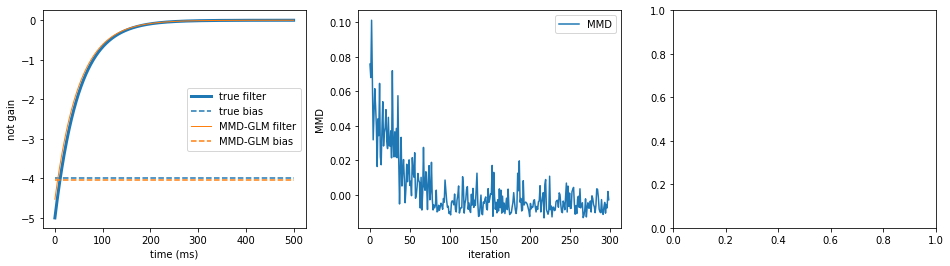

In [25]:
palette = dict(true='C0', mmd='C1')
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(16, 4), ncols=3)
glm_true.eta.plot(ax=ax1, lw=3, color=palette['true'], label='true filter')
ax1.plot([glm_true.eta.support[0], glm_true.eta.support[1]], [glm_true.u0, glm_true.u0], '--', color=palette['true'], label='true bias')
mmdglm.eta.plot(ax=ax1, lw=1, color=palette['mmd'], label='MMD-GLM filter')
ax1.plot([mmdglm.eta.support[0], mmdglm.eta.support[1]], [mmdglm.u0, mmdglm.u0], '--', color=palette['mmd'], label='MMD-GLM bias')
ax1.set_xlabel('time (ms)')
ax1.set_ylabel('not gain')
ax1.legend()
ax2.plot(mmd, label='MMD')
ax2.set_xlabel('iteration')
ax2.set_ylabel('MMD')
ax2.legend()
ax3.plot(nll, label='NLL')
ax3.set_xlabel('iteration')
ax3.set_ylabel('NLL')
ax3.legend()

# fig.savefig('/home/diego/Dropbox/generative_glm/figures/learning_history_filter.pdf')

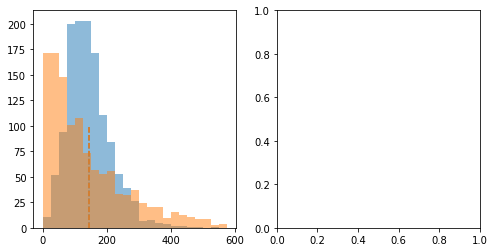

In [107]:
# num_epochs = 200
# lr = 5e-2

n = 100
eta_true = KernelFun.exponential([50], coefs=[-5])
glm_true = GLM(u0=-4, eta=eta_true.copy())

t = np.arange(0, 2000, 1)
_, _, mask_spikes_te = glm_true.sample(t, shape=(n,))
st_dc = SpikeTrain(t, mask_spikes_te)
isi_d = st_dc.isi_distribution(concatenate=False)
mean_d = np.mean(np.concatenate((isi_d)))

eta_fit = KernelFun.exponential([50], coefs=[0])
glm_fit = GLM(u0=-5, eta=eta_fit.copy())
u_fr_ml, r_fr_ml, mask_spikes_fr_ml = glm_fit.sample(t, shape=(n, ))
st_fr = SpikeTrain(t, mask_spikes_fr_ml)
isi_fr = st_fr.isi_distribution(concatenate=False)
mean_fr = np.mean(np.concatenate((isi_fr)))

phi1_d = np.array([np.sum(_isi) for _isi in isi_d])
phi2_d = np.array([np.sum(_isi**2) for _isi in isi_d])
counts_d = np.array([len(_isi**2) for _isi in isi_d])
aux_d = ((phi1_d**2 - phi2_d) / (counts_d * (counts_d - 1)))

phi1_fr = np.array([np.sum(_isi) for _isi in isi_fr])
phi2_fr = np.array([np.sum(_isi**2) for _isi in isi_fr])
counts_fr = np.array([len(_isi**2) for _isi in isi_fr])

gramian_d_d = aux_d[:, None] + aux_d[None, :] - 2 * (phi1_d / counts_d)[:, None] * (phi1_d / counts_d)[None, :]

# n_batch_te, n_batch_fr = r_te.shape[1], r_fr.shape[1]
# r_sum_te, r_sum_fr = torch.sum(r_te, 1), torch.sum(r_fr, 1)

# norm2_te = (torch.sum(r_sum_te**2) - torch.sum(r_te**2)) / (n_batch_te * (n_batch_te - 1))
# norm2_fr = (torch.sum(r_sum_fr**2) - torch.sum(r_fr**2)) / (n_batch_fr * (n_batch_fr - 1))
# mean_dot = torch.sum(r_sum_te * r_sum_fr, 0) / (n_batch_te * n_batch_fr)
# d = (norm2_te + norm2_fr - 2 * mean_dot)    

# print('u0 true/fit', glm_true.u0, glm_fit.u0)
fig, (ax1, ax2) = plt.subplots(figsize=(8, 4), ncols=2)
# glm_true.eta.plot(ax=ax1)
# glm_fit.eta.plot(ax=ax1)
bins = np.arange(0, 600, 25)
ax1.hist(np.concatenate((isi_d)), bins=bins, alpha=0.5)
ax1.hist(np.concatenate((isi_fr)), bins=bins, alpha=0.5)
ax1.plot([mean_d, mean_d], [0, 100], 'C0--')
ax1.plot([mean_fr, mean_fr], [0, 100], 'C1--')

# fig, (ax1, ax2) = plt.subplots(figsize=(12, 4), nrows=1, ncols=2)
# st_dc.plot(ax=ax1, marker='.', ms=0.7)

In [106]:
gramian_d_d

array([[-737.49704142, -114.21428571, -143.36813187, ..., -299.29684418,
         -87.43406593, -580.10722611],
       [-114.21428571, -703.30690738, -493.28649922, ..., -520.6996337 ,
        -556.93956044,   91.15467865],
       [-143.36813187, -493.28649922, -330.44976452, ..., -383.21611722,
        -370.51098901,   52.53563104],
       ...,
       [-299.29684418, -520.6996337 , -383.21611722, ..., -449.60552268,
        -410.6007326 , -108.47902098],
       [ -87.43406593, -556.93956044, -370.51098901, ..., -410.6007326 ,
        -422.36813187,  113.2022977 ],
       [-580.10722611,   91.15467865,   52.53563104, ..., -108.47902098,
         113.2022977 , -424.61616162]])